In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

emotion = load_dataset("emotion")

c:\Users\User\.conda\envs\torch\Lib\site-packages\datasets\load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


# 1. Pandas exploration

In [2]:
emotion.set_format("pandas")
train_df = emotion["train"][:]
test_df = emotion["test"][:]

In [3]:
train_df["lbl_name"] = train_df["label"].apply(lambda x: emotion["train"].features["label"].int2str(x))
train_df

,text,label,lbl_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


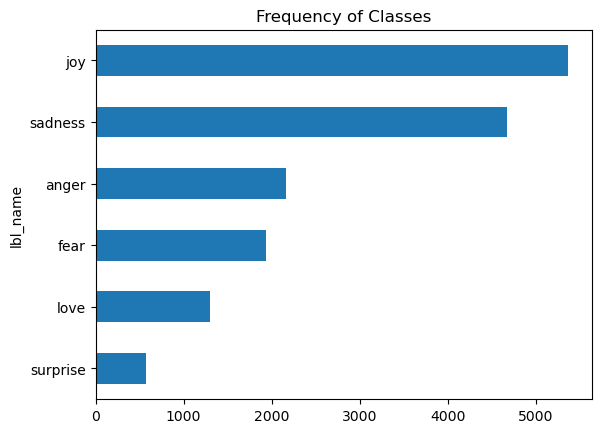

In [4]:
# Check for data imbalances
train_df["lbl_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

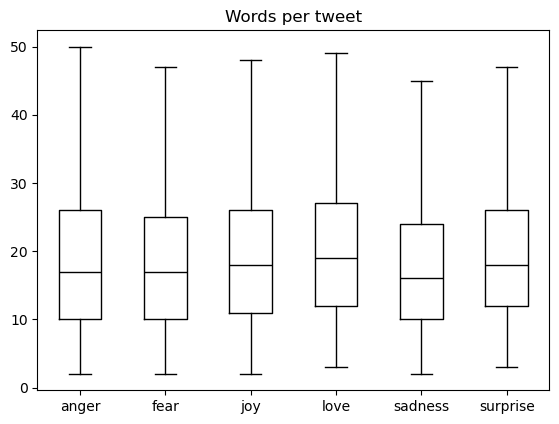

In [5]:
# Check for tweet length
train_df["Words per tweet"] = train_df["text"].str.split().apply(len)
train_df.boxplot("Words per tweet", by="lbl_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [6]:
emotion.reset_format()

# 2. After pandas

In [11]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(
    model_ckpt,
)